In [1]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/datatype-pic/types-of-data--1024x555.png


#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import math
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

#### Read files

In [3]:
df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
df = pd.concat([df_train,df_test],axis = 0,ignore_index = True)

##### Open the text file that contains the description of various variables. Create a dictionary that takes in the key as column name and gives out description

In [4]:
## Create a dictionary to see the description of the column names
with open("/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt","r") as f:
        texts = f.readlines()

newlist = list()
for col in df.columns:
    for text in texts:
        if col in text:
            newlist.append(text.split(":"))
            
desc = dict()
for item in newlist:
    if len(item)==2:
        desc[item[0]] = item[1]

## Example     
print(desc["YearRemodAdd"])
print(desc["LandSlope"])
print(desc["MoSold"])

 Remodel date (same as construction date if no remodeling or additions)

 Slope of property

 Month Sold (MM)



#### Explore Dataset

In [5]:
df_train.head(10).style.background_gradient(cmap = "viridis")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000000,14115,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,nan,Attchd,1993.000000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,nan,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000000,10084,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,nan,nan,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000000,6120,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,nan,nan,nan,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000000,7420,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,B

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [7]:
df.describe().transpose().style.background_gradient(cmap = "magma")

,count,mean,std,min,25%,50%,75%,max
Id,2919.000000,1460.000000,842.787043,1.000000,730.500000,1460.000000,2189.500000,2919.000000
MSSubClass,2919.000000,57.137718,42.517628,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,2433.000000,69.305795,23.344905,21.000000,59.000000,68.000000,80.000000,313.000000
LotArea,2919.000000,10168.114080,7886.996359,1300.000000,7478.000000,9453.000000,11570.000000,215245.000000
OverallQual,2919.000000,6.089072,1.409947,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,2919.000000,5.564577,1.113131,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,2919.000000,1971.312778,30.291442,1872.000000,1953.500000,1973.000000,2001.000000,2010.000000
YearRemodAdd,2919.000000,1984.264474,20.894344,1950.000000,1965.000000,1993.000000,2004.000000,2010.000000
MasVnrArea,2896.000000,102.201312,179.334253,0.000000,0.000000,0.000000,164.000000,1600.000000
BsmtFinSF1,2918.000000,441.423235,455.610826,0.000000,0.000000,368.500000,733.000000,5644.000000


In [8]:
print(df_train.shape)
print(df_test.shape) # the SalePrice column is missing in test data, which we need to predict.

(1460, 81)
(1459, 80)


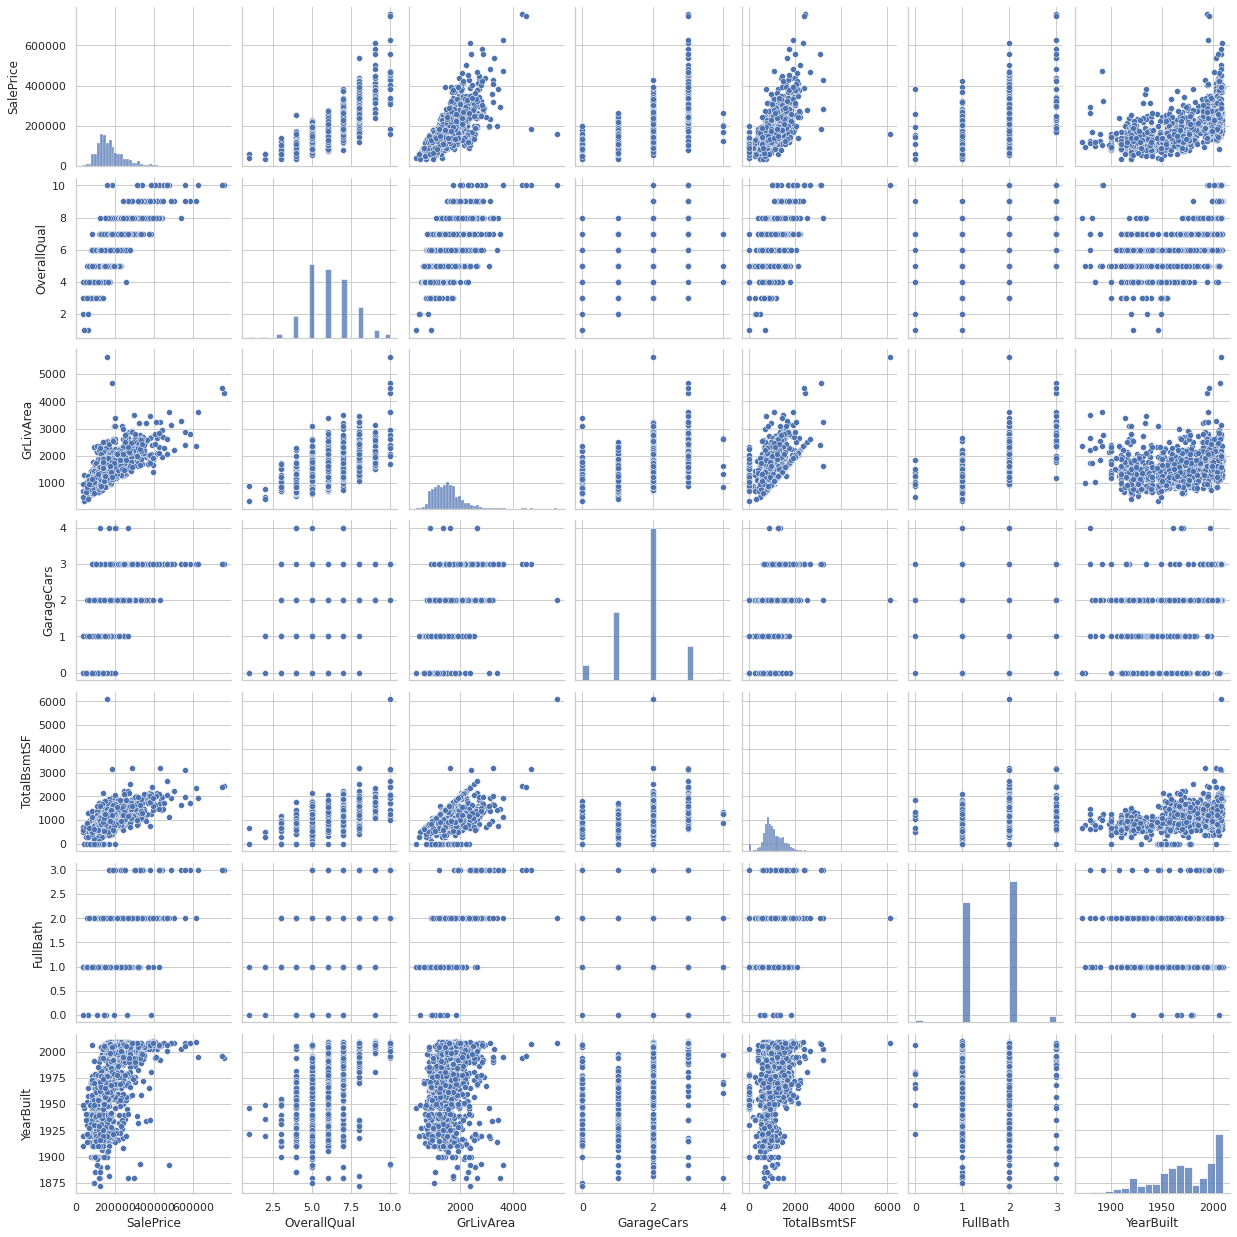

In [9]:
var_num = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt"]
sns.pairplot(df_train[var_num]);

#### Visualize dependent variable (SalePrice)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

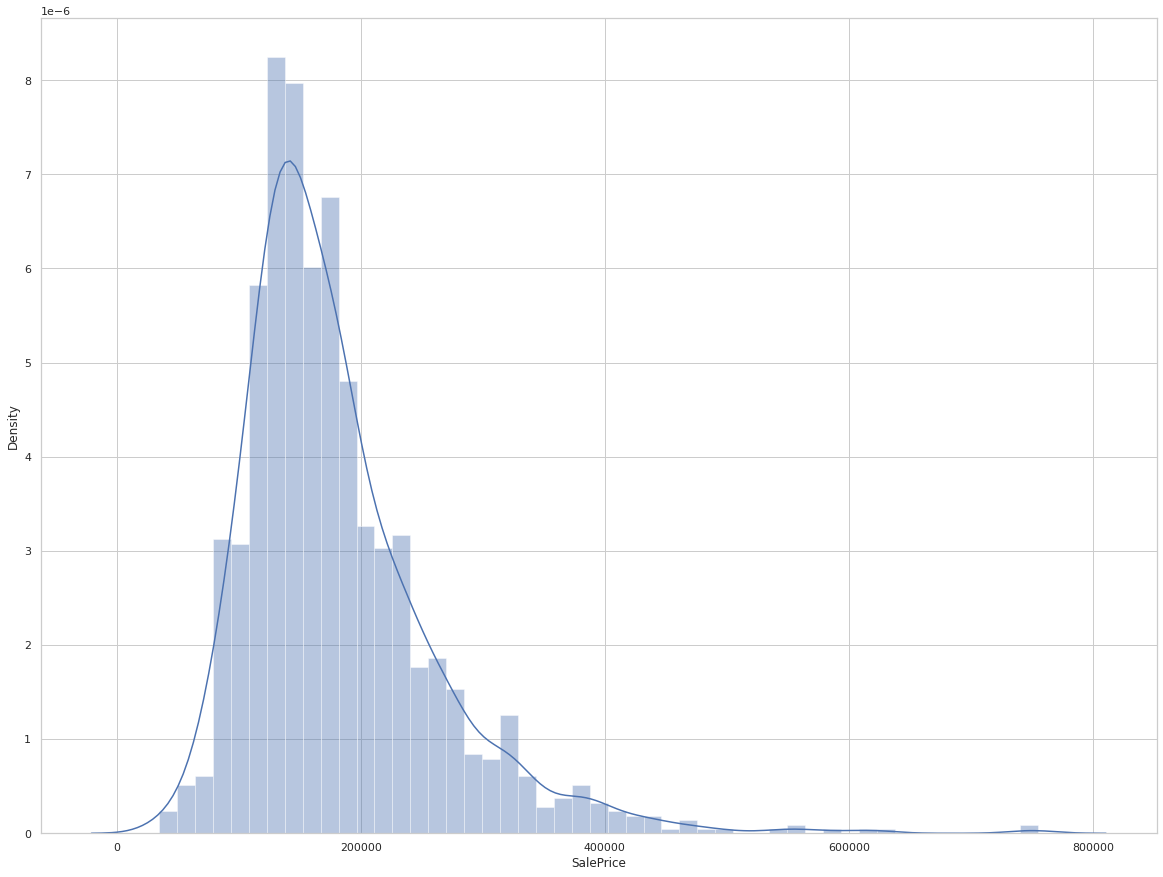

In [10]:
sns.distplot(df["SalePrice"])

##### We can see that the distribution is postivitely skewed.

In [11]:
df["SalePrice"].describe()  ##There is a huge difference between the min and max..

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='LogSalePrice', ylabel='Density'>

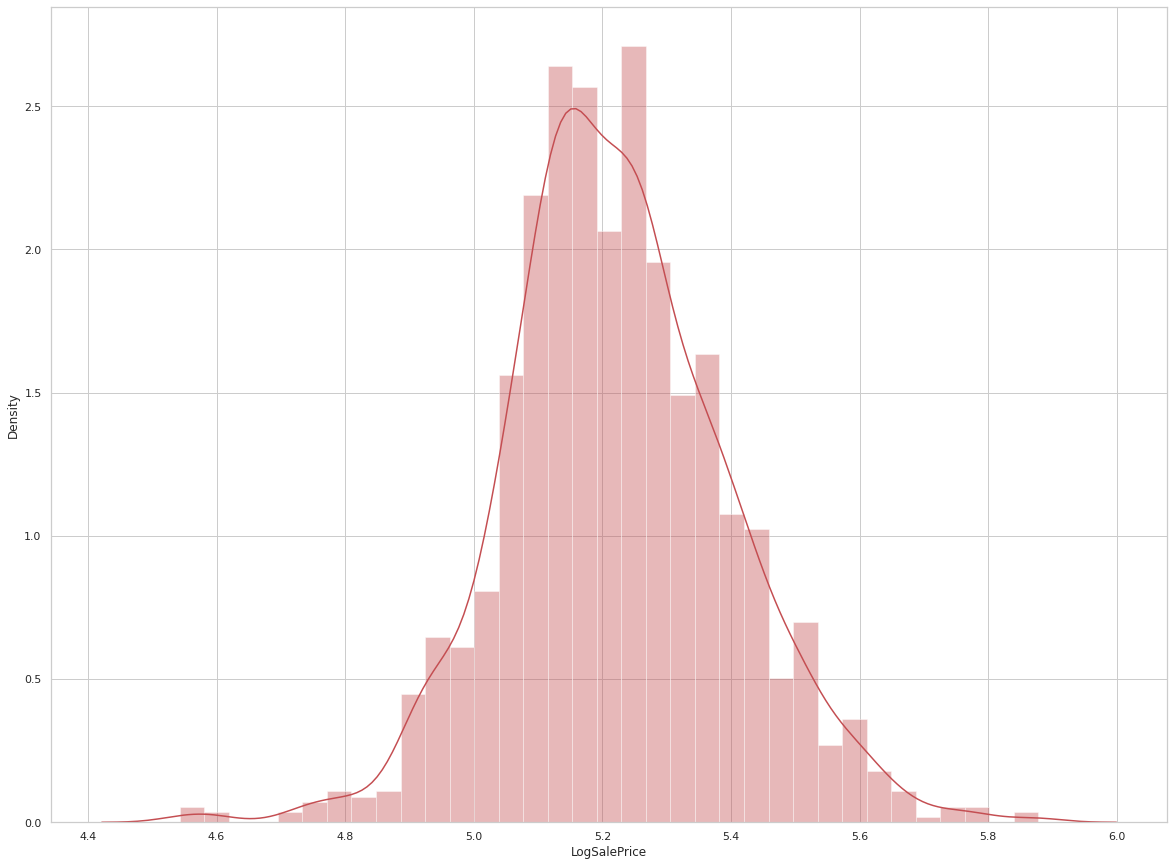

In [12]:
df["LogSalePrice"] = np.log10(df["SalePrice"])
sns.distplot(df["LogSalePrice"],color = 'r')

##### Since, the target variable is positively skewed, we would like to transform the variable using log of the price, which gave us a normally distributed chart, which is better for machine learning prediction

### Question 1: What features correlates the most with the Sale Price of the house?

In [13]:
## Lets create a list of column names for categorical and numerical features

cate_feat = list(df.select_dtypes(include = [object]).columns)
num_feat = list(df.select_dtypes(include = [int,float]).columns)

print(cate_feat)
print('\n')
print(num_feat)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',

Text(0.5, 1.0, 'SalePrice Correlation')

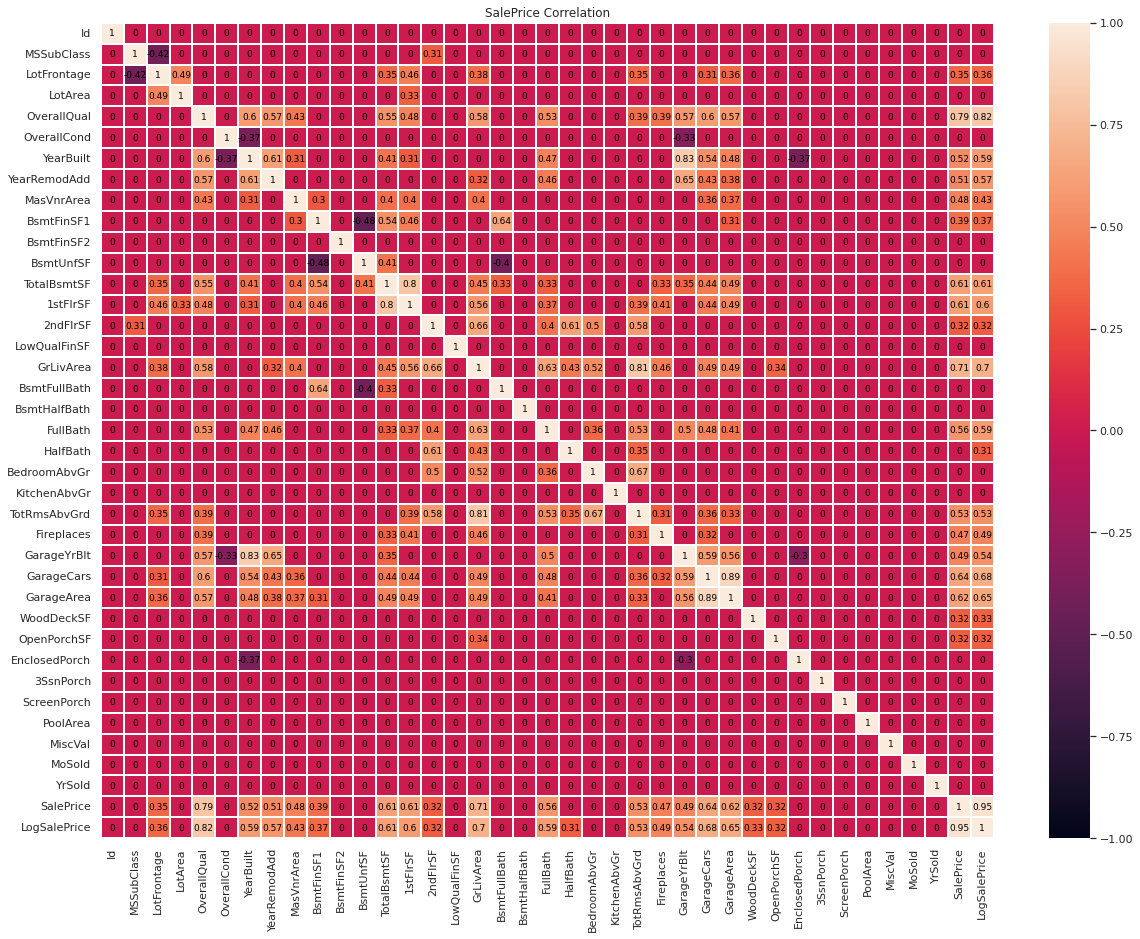

In [14]:
# Heatmap for all the remaining numerical data including the taget 'SalePrice'
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix
corr_matrix = df[num_feat].corr()

# Replace correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

# plot the heatmap
sns.heatmap(corr_matrix, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"},annot=True)
plt.title("SalePrice Correlation")

##### We can see that, The overall quality of the house and Ground living Area has 0.79 and 0.74 correlation with the SalePrice of the house, followed by Garagecars with 0.64 correlation.

In [15]:
## Lets visualize individually 

corr =df.corr()["SalePrice"].sort_values(ascending = False)[2:8] ## selecting cols other than Saleprice, LogPrice
corr

OverallQual   0.79
GrLivArea     0.71
GarageCars    0.64
GarageArea    0.62
TotalBsmtSF   0.61
1stFlrSF      0.61
Name: SalePrice, dtype: float64

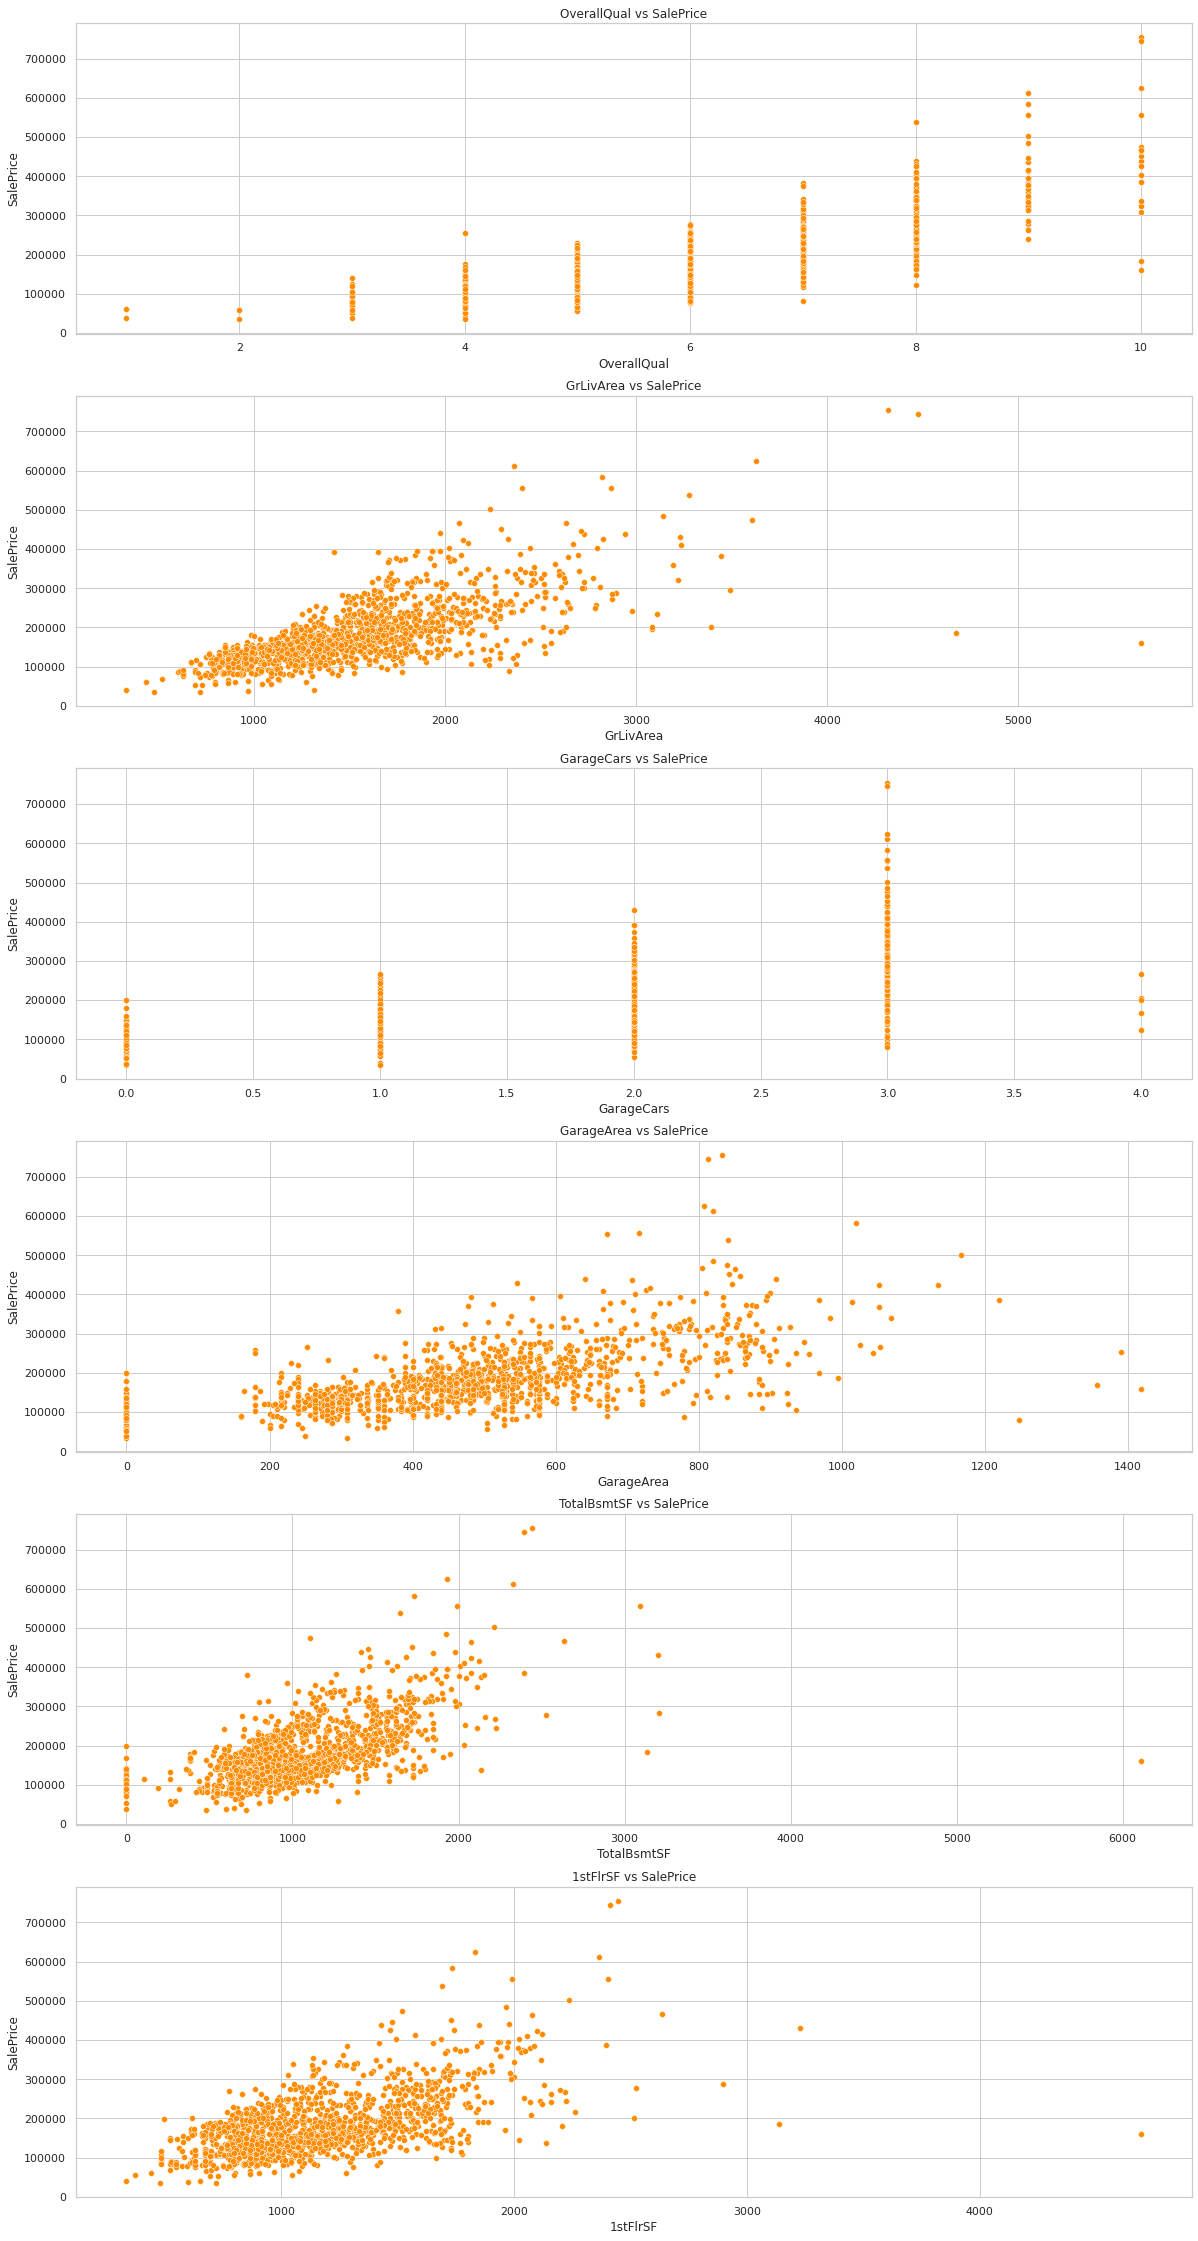

In [16]:
f,ax = plt.subplots(nrows = 6,ncols = 1, figsize = (20,40))
for i,col in enumerate(corr.index):    
    sns.scatterplot(x = col, y = "SalePrice", data = df, ax = ax[i], color = 'darkorange')
    ax[i].set_title(f'{col} vs SalePrice')
   

##### We can see the features above are quite linear to the Sale Price suggesting positive correlation.

### Question 1: What year were most of the houses built (Top 10), and does the year built say anything regarding the sale price?

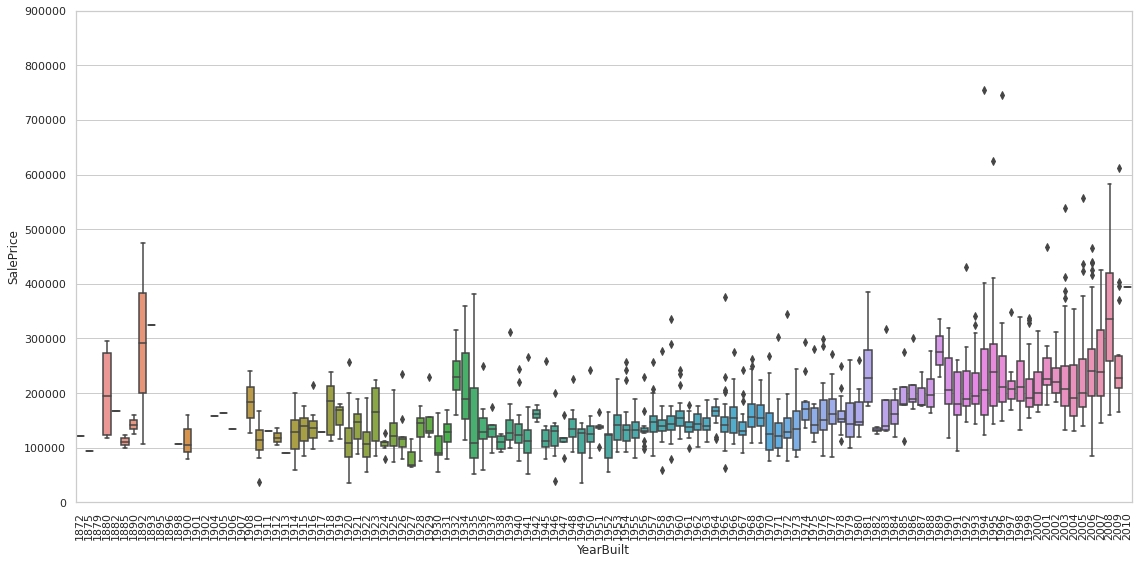

In [17]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x="YearBuilt", y="SalePrice", data=df,)
fig.axis(ymin=0, ymax=900000);
plt.xticks(rotation=90);
plt.tight_layout()

Text(0.5, 1.0, 'Year Built')

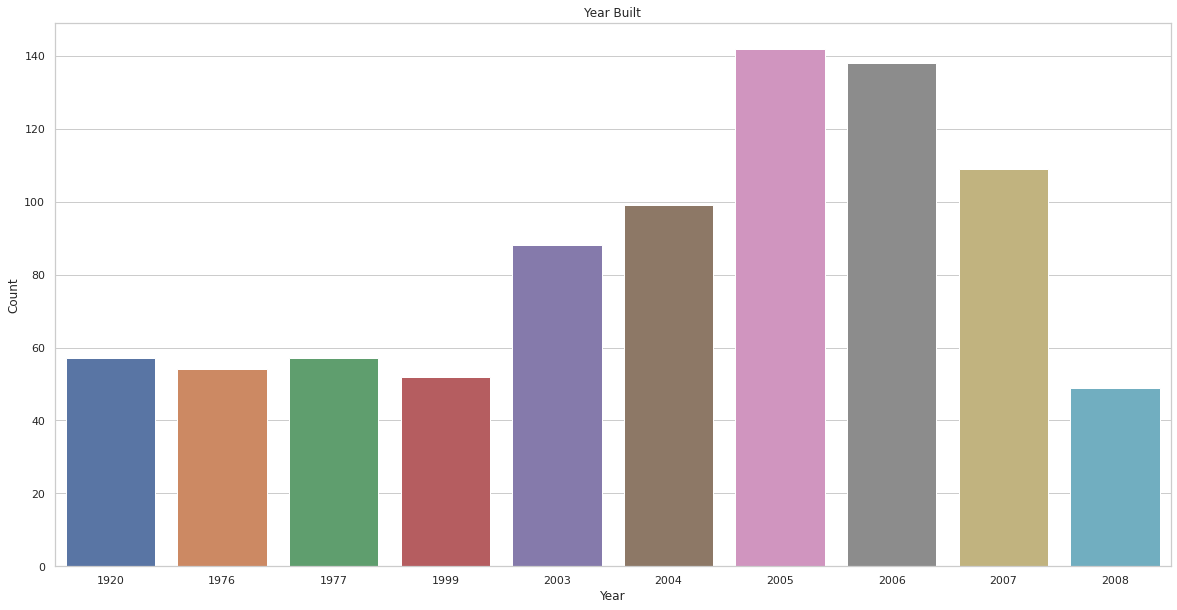

In [18]:
yr_built = pd.DataFrame({"Count":df["YearBuilt"].value_counts()[:10]}).reset_index()
yr_built.rename(columns={'index':'Year'},inplace=True)
plt.figure(figsize = (20,10))
sns.barplot(x = 'Year', y = "Count", data = yr_built)
plt.title("Year Built")

<AxesSubplot:xlabel='MoSold'>

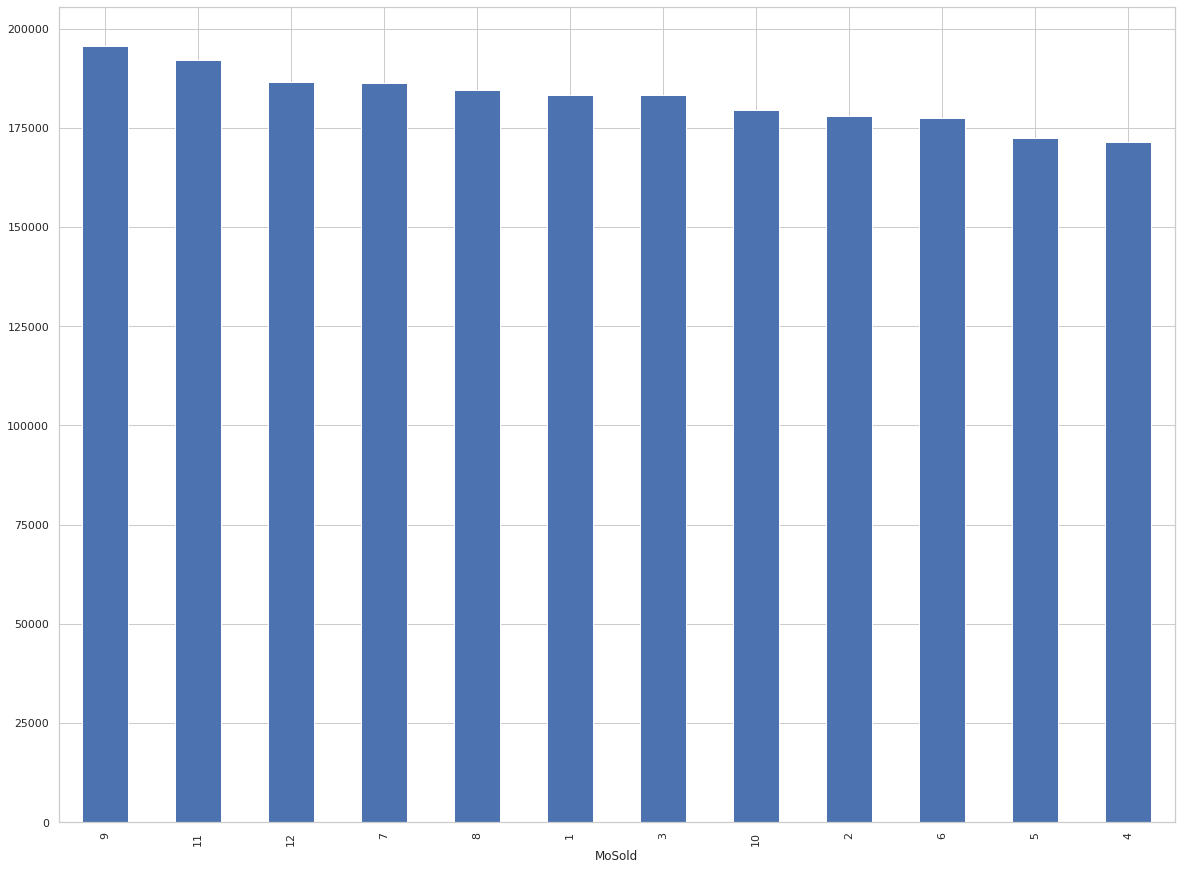

In [19]:
## As a side question, lets see if there is a huge difference in sale price based on different months

df.groupby("MoSold").mean()["SalePrice"].sort_values(ascending = False).plot(kind = 'bar')

##### Most of the houses were built in the year 2005, 2006. On average the houses built after 1980 have higher Saleprice. There is also no significance difference in terms of average saleprice based on month. September taking the lead.

## Handling Missing Data

In [20]:
## Number of missing values in categorical features
df[cate_feat].isnull().sum()

MSZoning            4
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
dtype: int64

In [21]:
## Number of missing values in numerical features
df[num_feat].isnull().sum()

Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
LogSalePrice     1459
dtype: int64

### Dealing with null values in numerical features

##### Since there is alot missing in lotfrontage, and is related to lotArea as seen below, we will use linear reg to fill in the missing values for LotFrontage

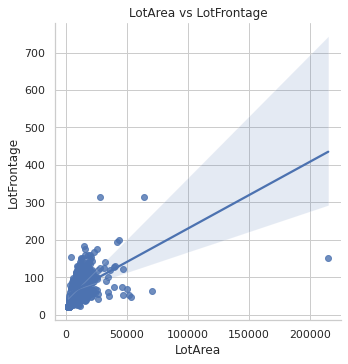

In [22]:
sns.lmplot(x="LotArea",y="LotFrontage",data = df)
plt.ylabel("LotFrontage")
plt.xlabel("LotArea")
plt.title("LotArea vs LotFrontage")
plt.show()

In [23]:
lm = LinearRegression()
lm_X = df[df['LotFrontage'].notnull()]['LotArea'].values.reshape(-1,1)
lm_y = df[df['LotFrontage'].notnull()]['LotFrontage'].values
lm.fit(lm_X,lm_y)
df['LotFrontage'].fillna((df['LotArea'] * lm.coef_[0] + lm.intercept_), inplace=True)
df['LotFrontage'] = df['LotFrontage'].apply(lambda x: int(x))

##### Since its only few values missing in each category, we dont need to explore alot. Just filling na values with median and mean

In [24]:
df["GarageYrBlt"].fillna(df["GarageYrBlt"].median(),inplace = True)
df["BsmtFinSF1"].fillna(df["BsmtFinSF1"].mean(),inplace = True)
df["BsmtFinSF2"].fillna(df["BsmtFinSF2"].mean(),inplace = True)
df["BsmtUnfSF"].fillna(df["BsmtUnfSF"].mean(),inplace = True)
df["TotalBsmtSF"].fillna(df["TotalBsmtSF"].mean(),inplace = True)
df["BsmtFullBath"].fillna(df["BsmtFullBath"].median(),inplace = True)
df["BsmtHalfBath"].fillna(df["BsmtHalfBath"].median(),inplace = True)
df["GarageArea"].fillna(df["GarageArea"].mean(),inplace = True)
df["GarageCars"].fillna(int(df["GarageCars"].median()),inplace = True)
df["MasVnrArea"].fillna(df["MasVnrArea"].median(),inplace = True)

### Dealing with null values in Categorical features

In [25]:
## Since more than 90% of the column is null
df.drop(["Alley","FireplaceQu","PoolQC","MiscFeature"], axis = 1,inplace = True)
df.drop(["Fence"], axis = 1,inplace = True)

# Remove the items from the column list
for item in cate_feat:
    if item in ["Alley","FireplaceQu","PoolQC","MiscFeature"]:
        cate_feat.remove(item) 
cate_feat.remove("Fence")   

# Fill null values with none for items that are missing the item and mode for the rest of the missing values
cate_none = ["BsmtExposure", "BsmtFinType2", "BsmtCond", "BsmtQual", "BsmtFinType1"]
cate_mode = ["Electrical", "Functional", "KitchenQual", "Exterior1st", "Exterior2nd", "MSZoning", "SaleType", "MasVnrType", "GarageFinish", "GarageQual", "GarageCond", "GarageType","Utilities"]

for col in cate_none:
    df[col].fillna('none',inplace = True)

for col in cate_mode:
    df[col].fillna(df[col].mode()[0],inplace = True)

print(f"Null values: {df.drop(['SalePrice','LogSalePrice'],axis = 1).isnull().sum().sum()}")

Null values: 0


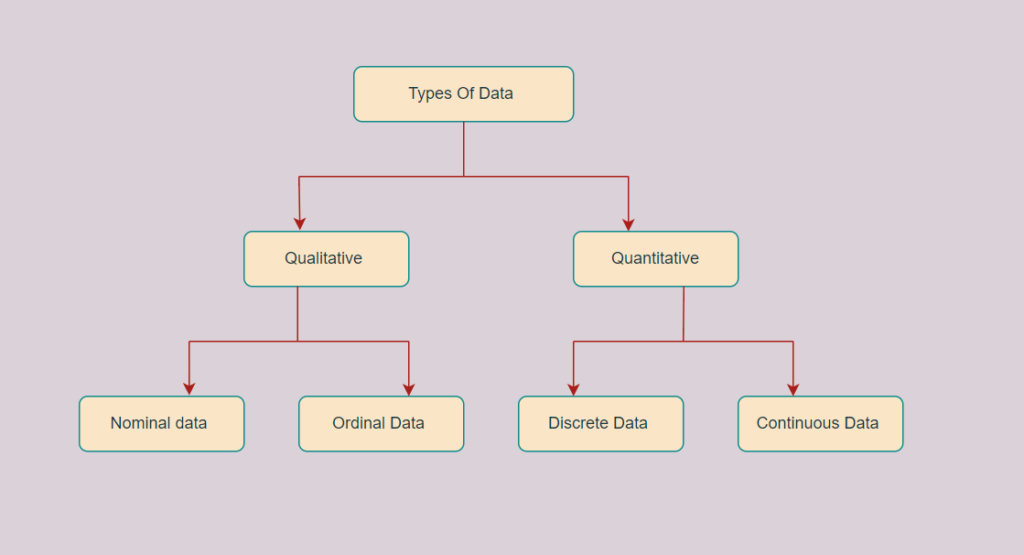

In [26]:
Image("/kaggle/input/datatype-pic/types-of-data--1024x555.png")

## Categorical Variable Encoding

#### It is very important to understand the data-type while analyzing the dataset. Since proper grouping of data will give better predictive results. There are 4 types of Data, namely Discrete, Continuous, Nominal and Ordinal. For categorical data, we will be dealing with Nominal and Ordinal.

#### -ordinal: There is a clear order in the category, example: poor, good, excellent etc
#### -Nominal: These are usually names without and order

#### We will be encoding categories using 3 different methods. 
#### - ordinal grouping (for ordinal category)
#### - Get dummies (for categories with less than 8(upto you) unique items)
#### - Top (8-10) freq occuring item within a category 

In [27]:
## Lets create a dataframe of category with its unique features

unq_col = dict()
for col in cate_feat:
    unq_col[col] = list(df[col].unique())

unq_df = pd.DataFrame.from_dict(unq_col, orient="index").replace({None:0})
unq_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
MSZoning,RL,RM,C (all),FV,RH,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Street,Pave,Grvl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LotShape,Reg,IR1,IR2,IR3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LandContour,Lvl,Bnk,Low,HLS,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Utilities,AllPub,NoSeWa,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LotConfig,Inside,FR2,Corner,CulDSac,FR3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LandSlope,Gtl,Mod,Sev,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neighborhood,CollgCr,Veenker,Crawfor,NoRidge,Mitchel,Somerst,NWAmes,OldTown,BrkSide,Sawyer,...,Edwards,Timber,Gilbert,StoneBr,ClearCr,NPkVill,Blmngtn,BrDale,SWISU,Blueste
Condition1,Norm,Feedr,PosN,Artery,RRAe,RRNn,RRAn,PosA,RRNe,0,...,0,0,0,0,0,0,0,0,0,0
Condition2,Norm,Artery,RRNn,Feedr,PosN,PosA,RRAn,RRAe,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
## Deealing with the Ordinal var first, These rep some kind of order
cate1 = ["BsmtCond"]
cate1_item = ['none',"Po", "Fa", "TA", "Gd"]

cate2 = ["BsmtExposure"]
cate2_item = ['none','No','Mn','Av','Gd']

cate3 = ["BsmtQual"]
cate3_item = ['none',"Fa","TA","Gd", "Ex"]

cate4 = ["ExterCond", "HeatingQC"]
cate4_item = ["Po", "Fa", "TA", "Gd", "Ex"]

cate5 = ["ExterQual", "KitchenQual"]
cate5_item = ["Fa", "TA", "Gd", "Ex"]

cate6 = ["GarageQual", "GarageCond"]
cate6_item = ['none',"Po", "Fa", "TA", "Gd", "Ex"]

cate7 = ["BsmtFinType1", "BsmtFinType2"]
cate7_item = ['none',"Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]

cate = [cate1,cate2,cate3,cate4,cate5,cate6,cate7]
cate_item = [cate1_item,cate2_item,cate3_item,cate4_item,cate5_item,cate6_item,cate7_item]

In [29]:
# Takes the items in a category and converts into numerical value ( with order respected)
for idx in range(len(cate)):
    encoder = OrdinalEncoder(categories = [cate_item[idx]])
    
    for col in cate[idx]:
        df[col] = encoder.fit_transform(df[[col]])

#### One-Hot Encoding

In [30]:
cate_ord = cate1+cate2+cate3+cate4+cate5+cate6+cate7

cate_one_hot = list()
cate_target_var = list()

for col in df[cate_feat].drop(cate_ord,axis = 1).columns:
    if len(df[col].unique()) <6:
        cate_one_hot.append(col)
    else:
        cate_target_var.append(col)

In [31]:
dummies_one_hot = pd.get_dummies(df[cate_one_hot], drop_first = True)
dummies_one_hot

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,MasVnrType_Stone,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y
0,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,1
1,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
3,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,0,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
2915,0,0,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
2916,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
2917,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1


In [32]:
## Finds the top 6 item in each category and creates a one hot encoding. Done on categories with alot
## of items to reduce the dimensions.
def one_hot(df):
    
    for col in df:
        top_10 = [item for item in df[col].value_counts().sort_values(ascending = False).head(6).index]
        
        for label in top_10:
            df[label] = np.where(df[col]==label,1,0)
            
    return df

In [33]:
# One hot encoding for nominal categorical data
df_tar_var = one_hot(df[cate_target_var])
df_tar_var.drop(cate_target_var,axis = 1,inplace = True)

In [34]:
# creating a dataframe with all converted values for prediction
df_final = pd.concat([df_tar_var,dummies_one_hot,df],axis = 1)
df_final.drop(cate_feat+cate_ord,axis = 1, inplace = True)


In [35]:
df_final.head()

,NAmes,CollgCr,OldTown,Edwards,Somerst,NridgHt,Norm,Feedr,Artery,RRAn,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,LogSalePrice
0,0,1,0,0,0,0,1,0,0,0,...,61,0,0,0,0,0,2,2008,"208,500.00",5.32
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,5,2007,"181,500.00",5.26
2,0,1,0,0,0,0,1,0,0,0,...,42,0,0,0,0,0,9,2008,"223,500.00",5.35
3,0,0,0,0,0,0,1,0,0,0,...,35,272,0,0,0,0,2,2006,"140,000.00",5.15
4,0,0,0,0,0,0,1,0,0,0,...,84,0,0,0,0,0,12,2008,"250,000.00",5.40


## Modelling

In [36]:
## Divide the dataset into train and test

train_df = df_final[df_final["SalePrice"].notnull()]
test_df = df_final[df_final["SalePrice"].isnull()]

print(train_df.shape)
print(test_df.shape)

(1460, 148)
(1459, 148)


In [37]:
## Split the dataset into X and Y
X_train = train_df.drop(["SalePrice","LogSalePrice"],axis = 1)
y_train = train_df["LogSalePrice"]
X_test = test_df.drop(["SalePrice","LogSalePrice"],axis = 1)

In [38]:
## Scale the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Selection

#### Cross validation to find the best predicting model

In [39]:
model = {
    'Lasso' : Lasso(),
    'Ridge' : Ridge(),
    'XGB' : XGBRegressor(),
    'LGBM' : LGBMRegressor(),
    'Gradient Boosting' : GradientBoostingRegressor(),
    'Bayesian Ridge' : BayesianRidge()
}

df_result = pd.DataFrame(columns =["Model_name","RMSE"])

for name,mod in model.items():
    
    cross_val = cross_validate(mod,X = X_train,y = y_train, cv = 10, scoring = (['neg_root_mean_squared_error']))
    
    df_result= df_result.append({'Model_name':name,"RMSE": np.abs(cross_val['test_neg_root_mean_squared_error']).mean()}, ignore_index = True)
    
df_result = df_result.sort_values('RMSE', ascending=True)

df_result

,Model_name,RMSE
4,Gradient Boosting,0.06
3,LGBM,0.06
2,XGB,0.06
5,Bayesian Ridge,0.07
1,Ridge,0.07
0,Lasso,0.17


#### We will choose Gradient Boosting an LGBM as it gave the best result for hyperparameter tuning.

#### GradientBoostingRegressor

In [40]:
gb = GradientBoostingRegressor()
params_gb = {
    'loss' : ('squared_error', 'absolute_error','huber'),
    'learning_rate' : (1.0, 0.1, 0.01),
    'n_estimators' : (100, 200, 300)
}

mod_gb = GridSearchCV(gb, params_gb, cv=10)
mod_gb.fit(X_train, y_train)
print('Best_hyperparameter : ', mod_gb.best_params_)

pred_gb = mod_gb.predict(X_train)
print(f'RMSE : {mean_squared_error(y_train,pred_gb, squared=False)}')
    
    


Best_hyperparameter :  {'learning_rate': 0.1, 'loss': 'squared_error', 'n_estimators': 300}
RMSE : 0.025368933869542174


#### LGBMRegressor

In [41]:
lgbm = LGBMRegressor()
params_lgbm = {
    'num_leaves' : (11, 31, 41),
    'learning_rate' : (0.5, 0.1, 0.05),
    'n_estimators' : (100, 200, 300)
}

mod_lgbm = GridSearchCV(lgbm, params_lgbm, cv=10)
mod_lgbm.fit(X_train, y_train)
print('Best_hyperparameter : ', mod_lgbm.best_params_)

pred_lgbm = mod_lgbm.predict(X_train)
print(f'RMSE : {mean_squared_error(y_train, pred_lgbm, squared=False)}')

Best_hyperparameter :  {'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 11}
RMSE : 0.029749579826275997


## Predict the test dataset

In [42]:
## Predict the test data and inverse log
y_pred = mod_gb.predict(X_test)
y_pred_inv = 10 ** y_pred

## Submission

In [43]:
submission['SalePrice'] = y_pred_inv
submission.to_csv('final_submission.csv', index=False)